## CREDIT CARD CUSTOMER BASE CLUSTERING

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

#Finding optimal no. of clusters
from scipy.spatial.distance import cdist

# to compute distances
from scipy.spatial.distance import pdist

# to perform K-Means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

In [2]:
# loading the dataset
d = pd.read_excel(r"C:\Users\LOKI\Downloads\Credit Card Customer Data.xlsx")

In [3]:
d.head(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


In [4]:
print(f"Shape: There are {d.shape[0]} rows and {d.shape[1]} columns")

Shape: There are 660 rows and 7 columns


In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [6]:
d.describe()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


In [7]:
d.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

## Univariate Analysis

In [8]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [9]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        hue=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

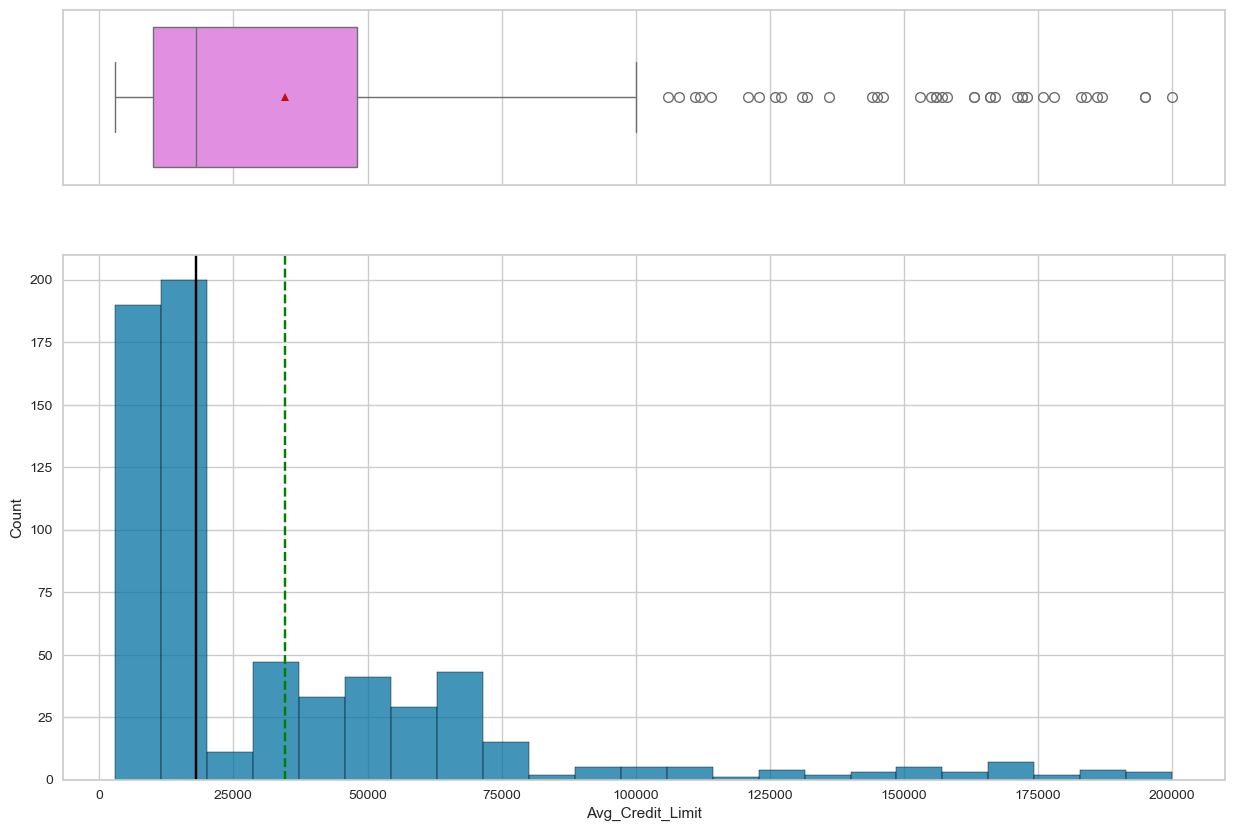

In [10]:
histogram_boxplot(d, "Avg_Credit_Limit")

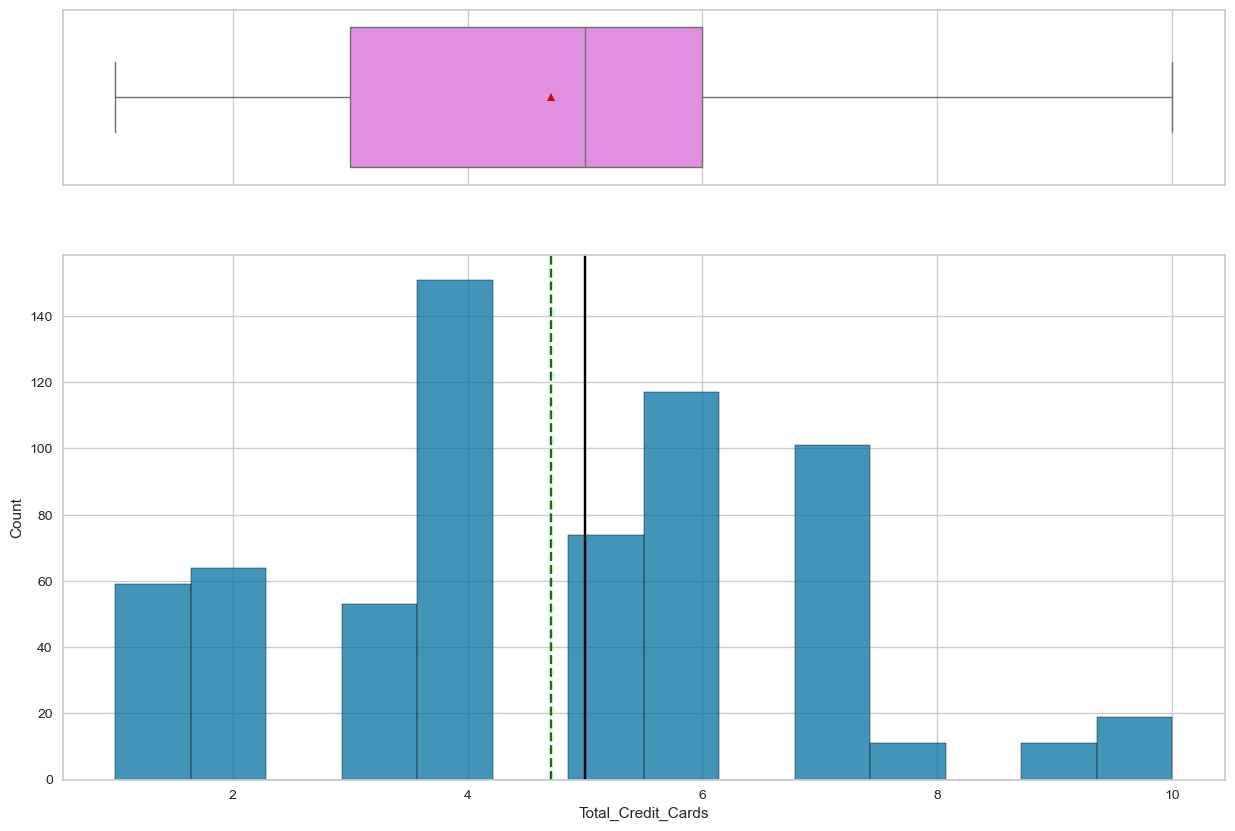

In [11]:
histogram_boxplot(d, "Total_Credit_Cards")

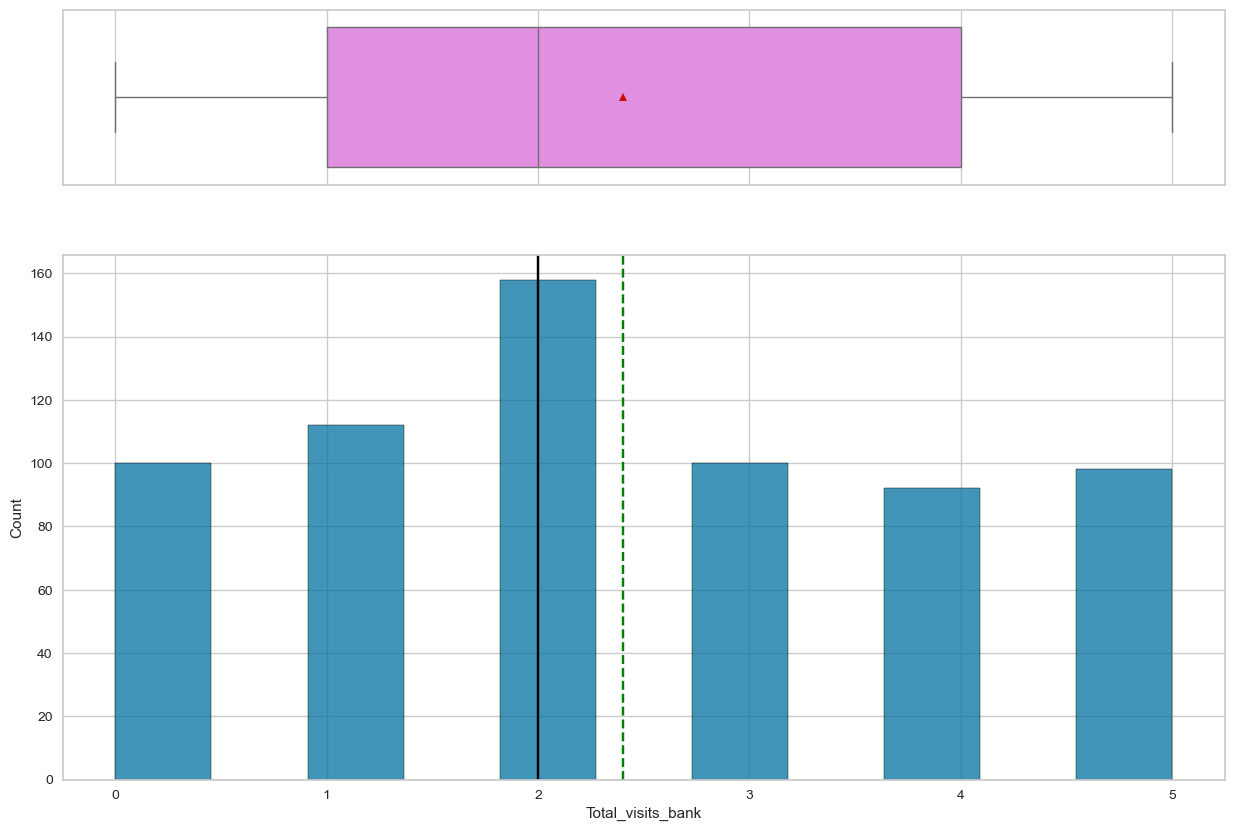

In [12]:
histogram_boxplot(d, "Total_visits_bank")

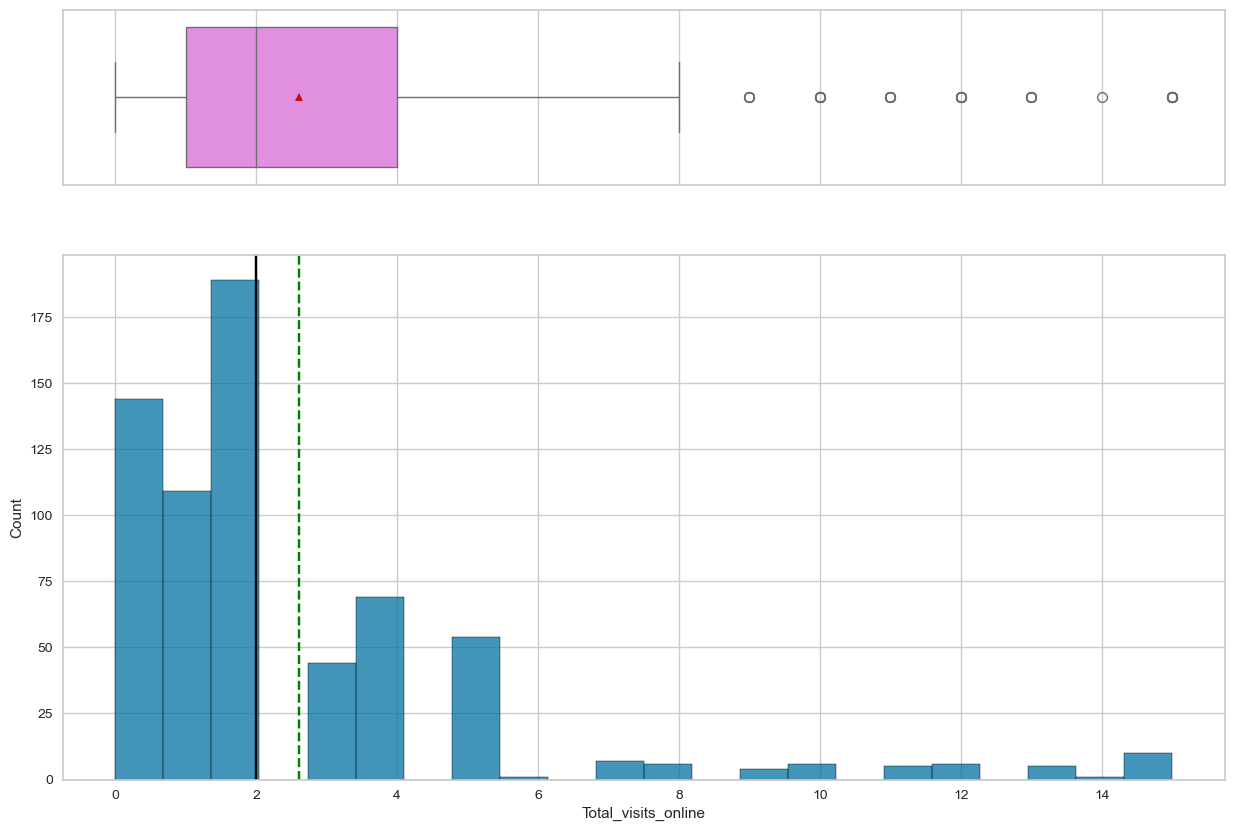

In [13]:
histogram_boxplot(d, "Total_visits_online")

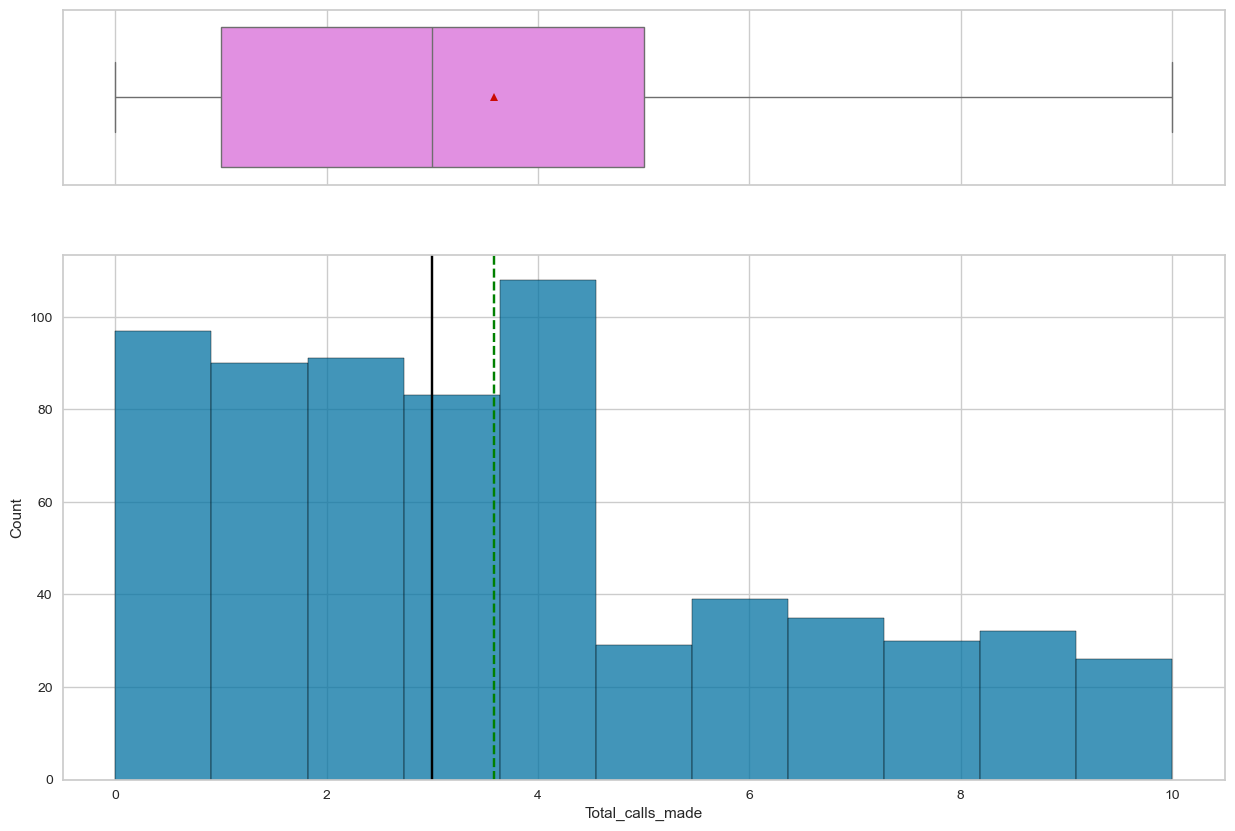

In [14]:
histogram_boxplot(d, "Total_calls_made")

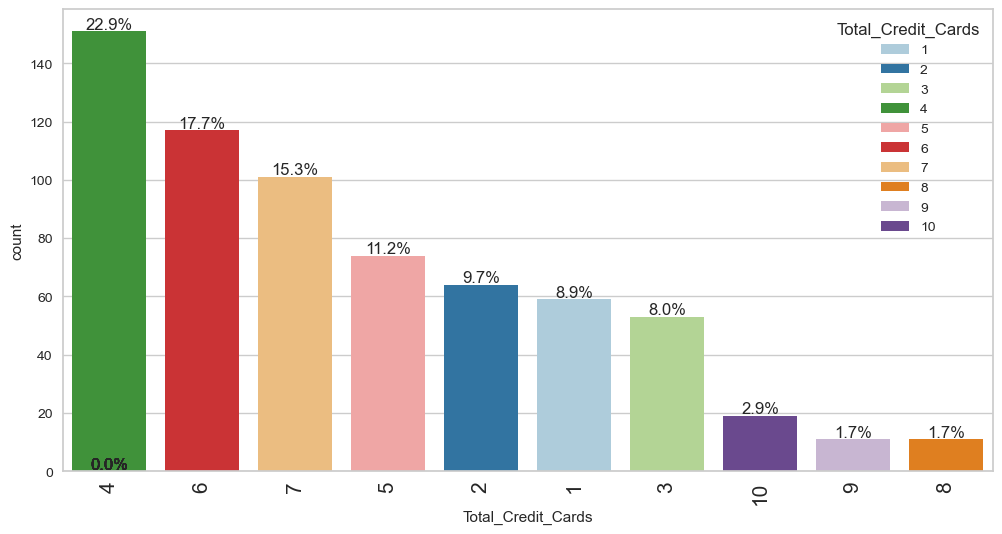

In [15]:
labeled_barplot(d,"Total_Credit_Cards",perc=True);

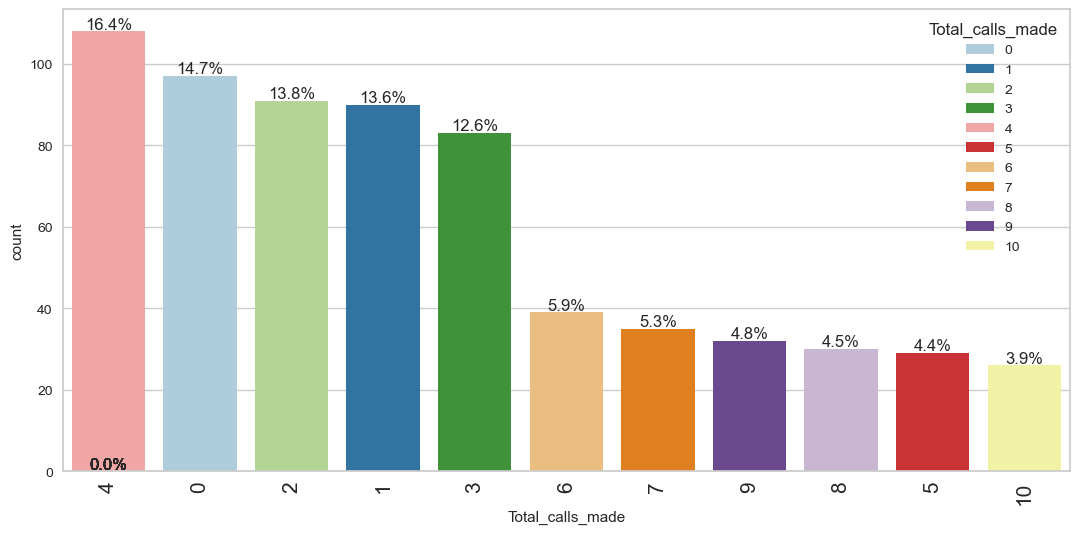

In [16]:
labeled_barplot(d,"Total_calls_made",perc=True);

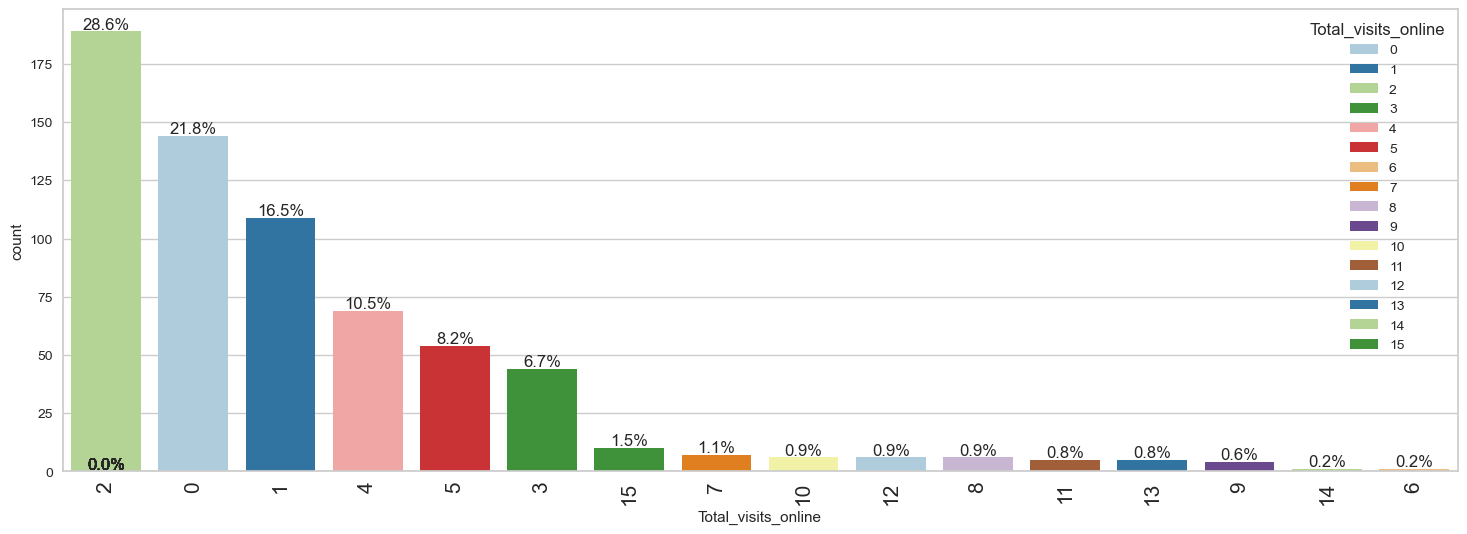

In [17]:
labeled_barplot(d,"Total_visits_online",perc=True);

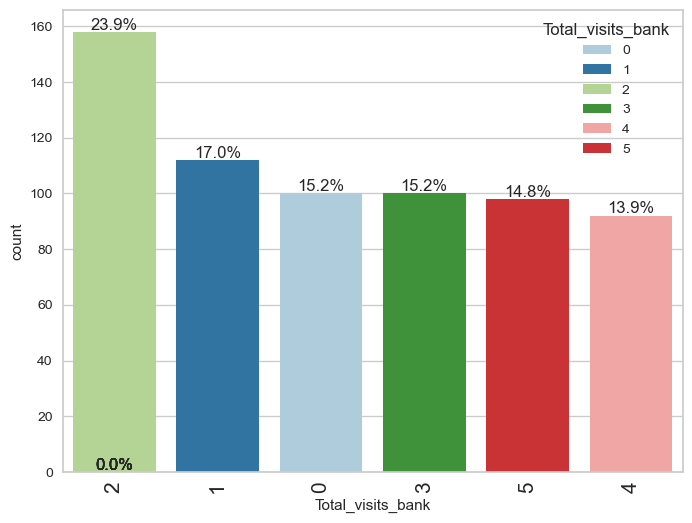

In [18]:
labeled_barplot(d,"Total_visits_bank",perc=True);

## Bivariate Analysis

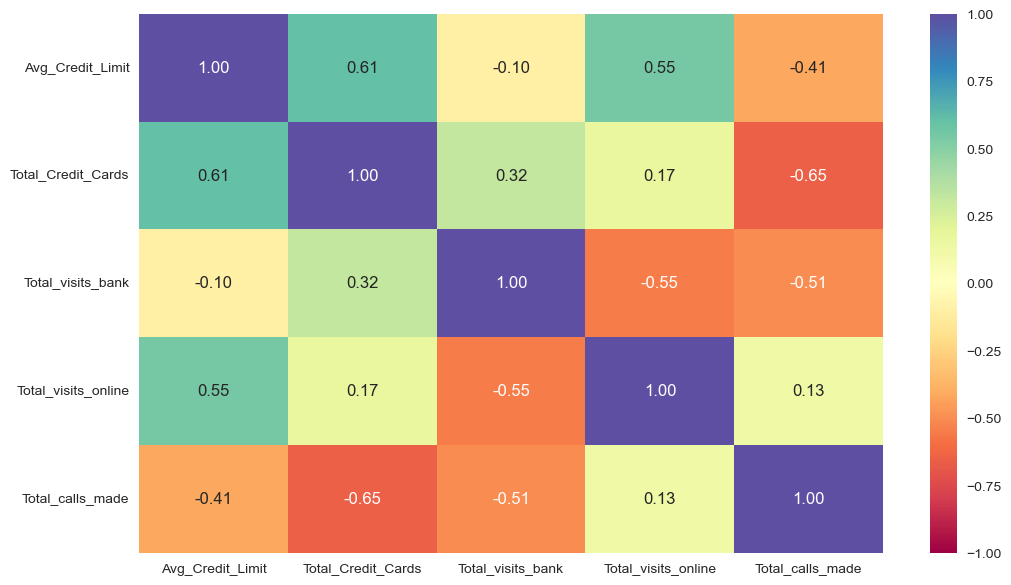

In [19]:
data=d.drop(["Sl_No","Customer Key"], axis=1)
cols_list = data.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(12,7))
sns.heatmap(d[cols_list].corr(),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap='Spectral')
plt.show()

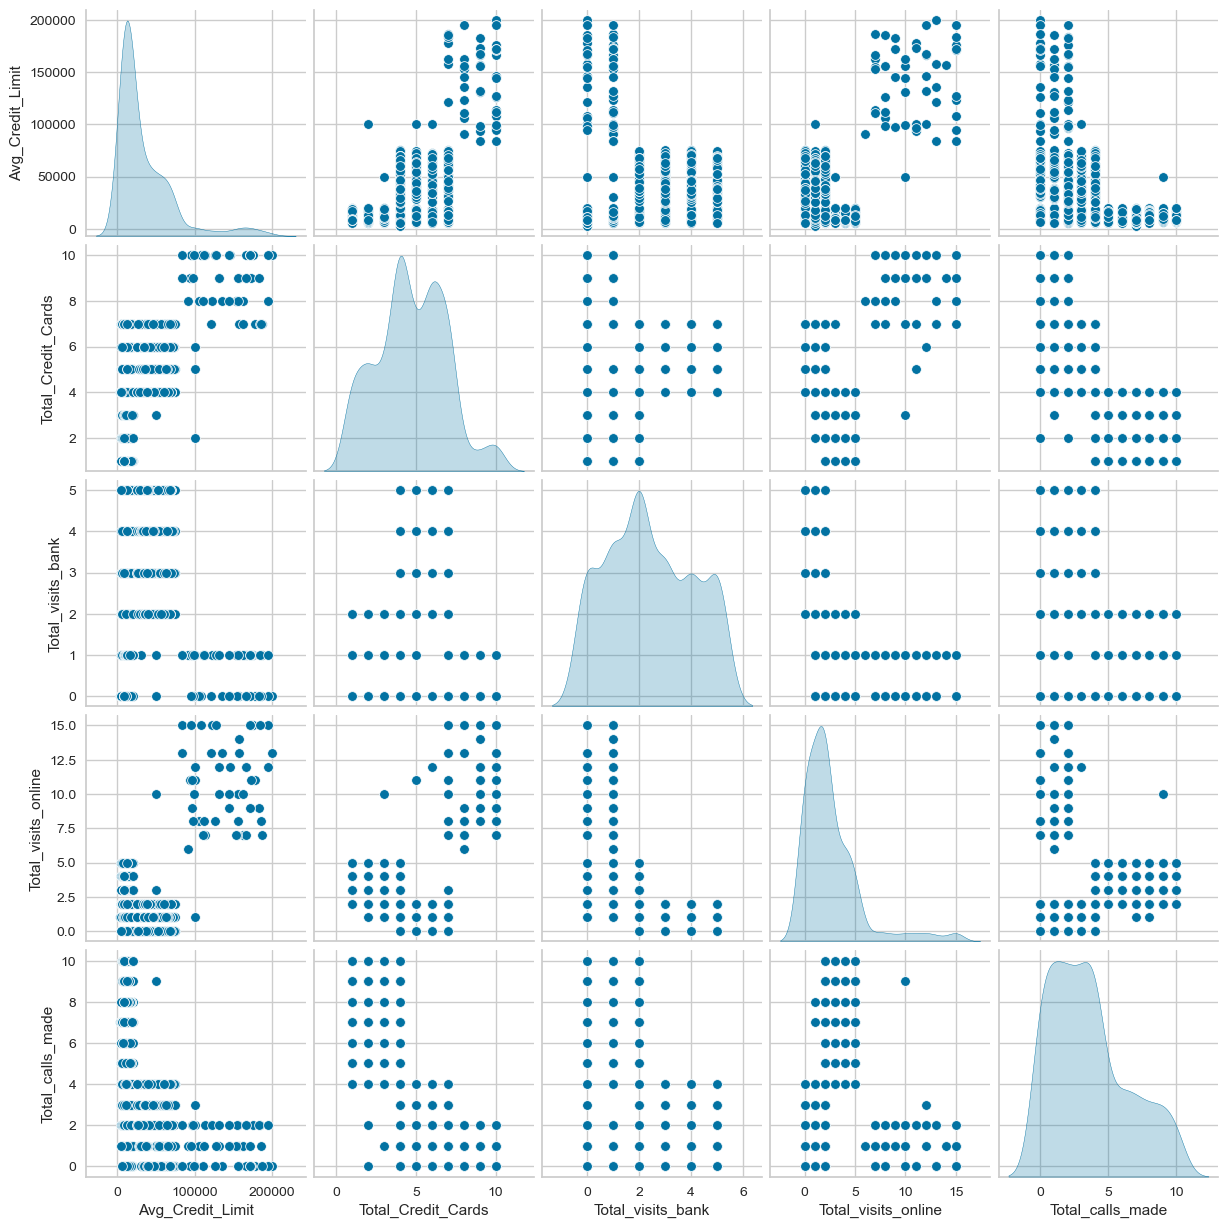

In [20]:
data=d.drop(["Sl_No","Customer Key"], axis=1)
sns.pairplot(data, diag_kind="kde");

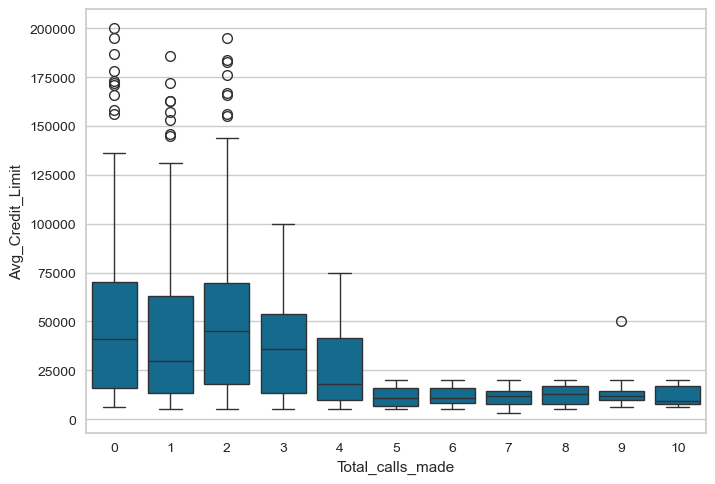

In [21]:
sns.boxplot(d,x='Total_calls_made',y='Avg_Credit_Limit');

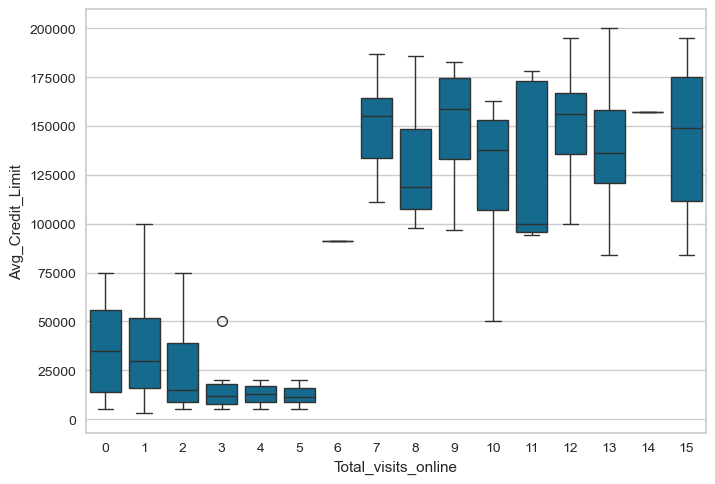

In [22]:
sns.boxplot(d,x='Total_visits_online',y='Avg_Credit_Limit');

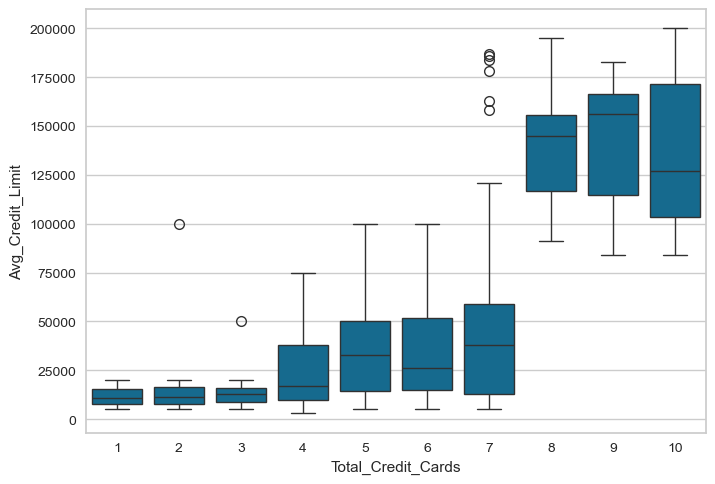

In [23]:
sns.boxplot(d,x='Total_Credit_Cards',y='Avg_Credit_Limit');

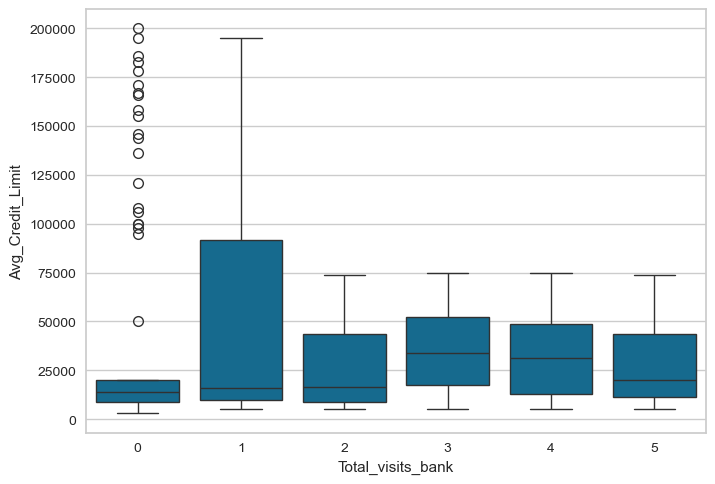

In [24]:
sns.boxplot(d,x='Total_visits_bank',y='Avg_Credit_Limit');

## Data Pre-Processing

In [25]:
d.duplicated().sum()

0

In [26]:
d.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

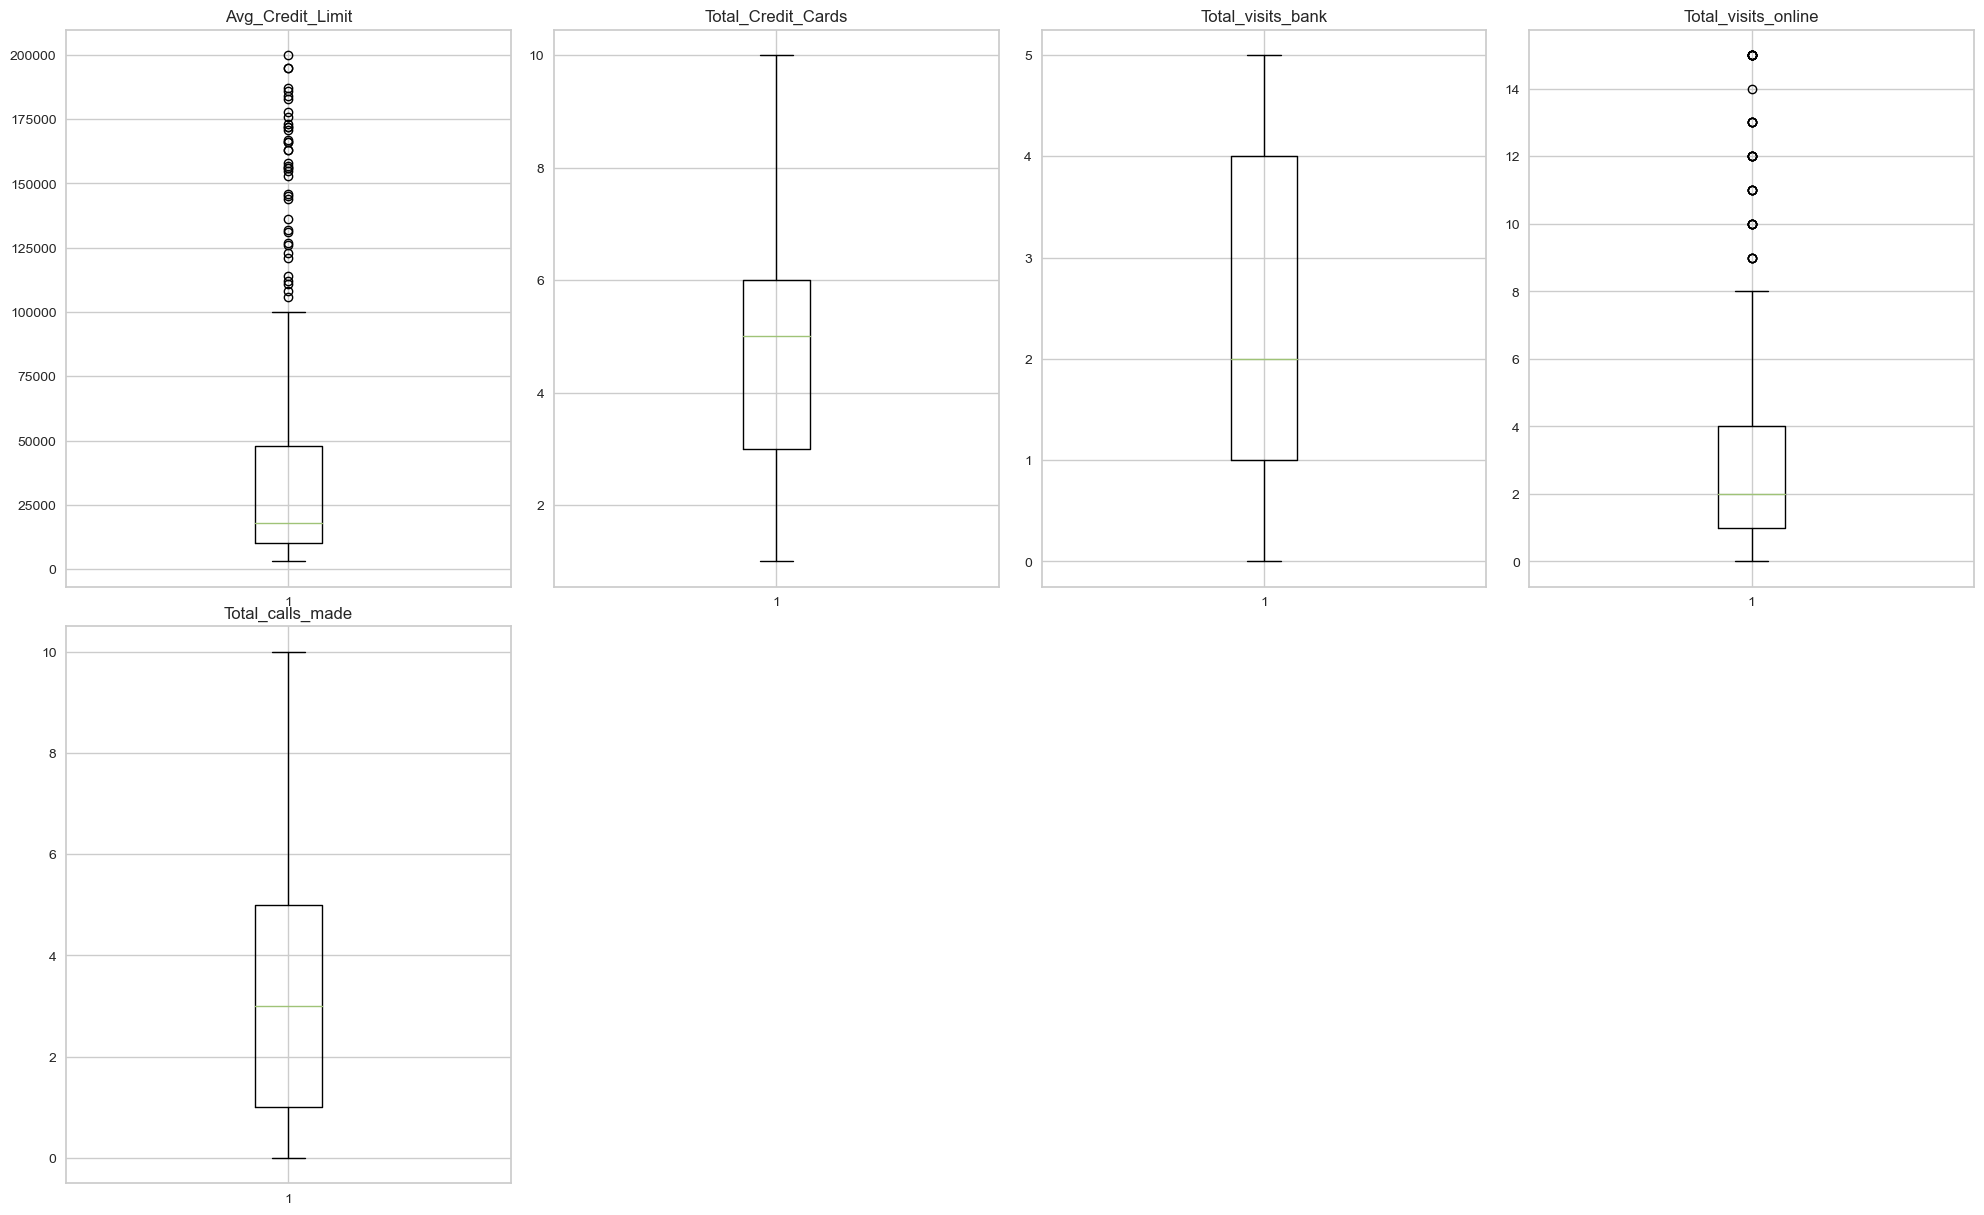

In [27]:
# outlier detection using boxplot
data=d.drop(["Sl_No","Customer Key"], axis=1)
num_cols = data.select_dtypes(include=np.number).columns.tolist()

# let's look at box plot to see if outliers have been treated or not
plt.figure(figsize=(20, 30))

for i, variable in enumerate(num_cols):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(d[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

### Scaling Dataset for Analysis

#### For K-means Clustering

In [28]:
d_Attr_1=d.drop(["Sl_No","Customer Key"], axis=1)
subset_km = d_Attr_1.copy()
subset_scaled_df_km = subset_km.apply(zscore)

#### For Hierarchical Clustering

In [29]:
d_Attr_2=d.drop(["Sl_No","Customer Key"], axis=1)
scaler = StandardScaler()
subset_hc = d_Attr_2.copy()
subset_scaled_hc = scaler.fit_transform(subset_hc)
subset_scaled_df_hc = pd.DataFrame(subset_scaled_hc, columns=subset_hc.columns)

## K-means Clustering

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9906725738045986
Number of Clusters: 6 	Average Distortion: 0.9526312205608284
Number of Clusters: 7 	Average Distortion: 0.9291610257377599
Number of Clusters: 8 	Average Distortion: 0.8933652082579997


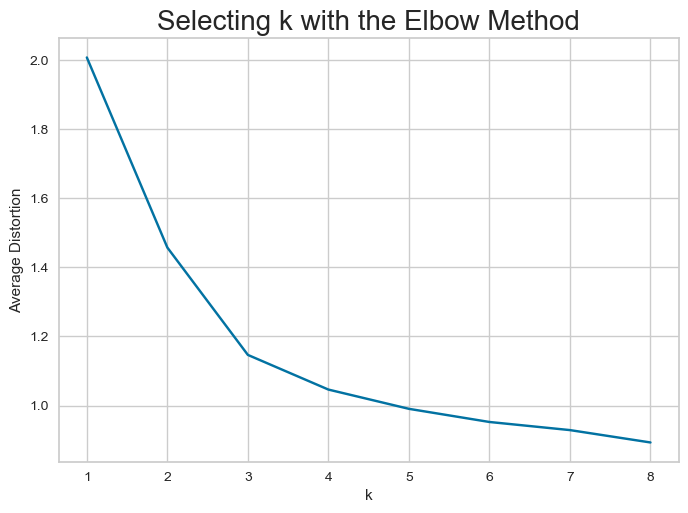

In [30]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df_km)
    prediction = model.predict(subset_scaled_df_km)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df_km, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df_km.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20);


### Silhouette scores

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.37685404115922083
For n_clusters = 5, silhouette score is 0.3186011416224773
For n_clusters = 6, silhouette score is 0.255906765297388
For n_clusters = 7, silhouette score is 0.22610558507916106
For n_clusters = 8, silhouette score is 0.23985392742822845
For n_clusters = 9, silhouette score is 0.21487854302351383


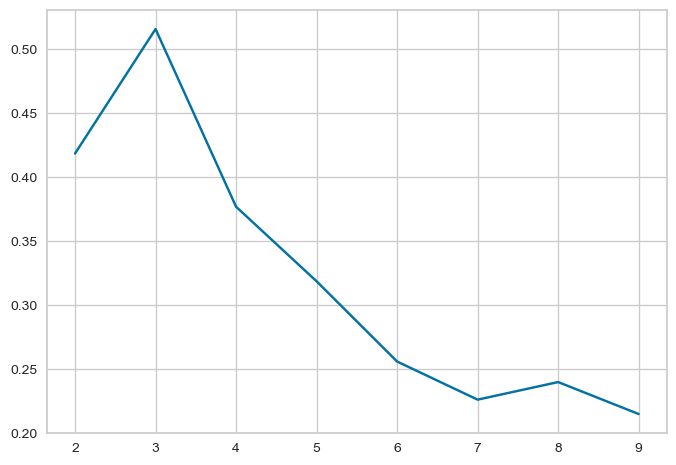

In [31]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df_km))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df_km, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score);

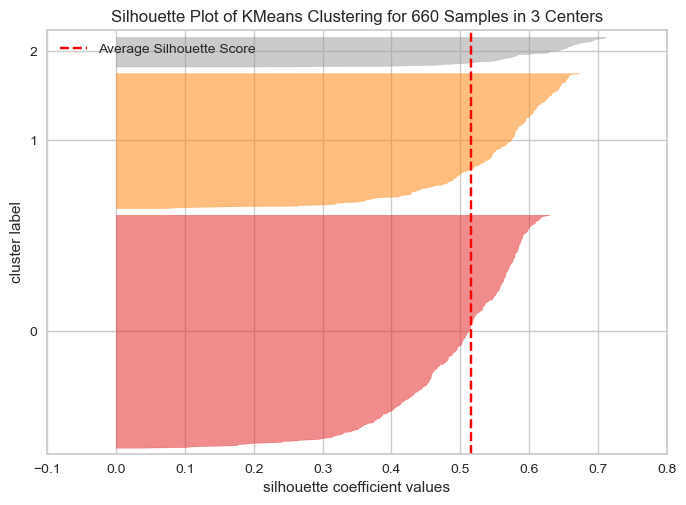

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df_km)
visualizer.show()

### Selecting final model

**Let's take 3 as the appropriate no. of clusters as the silhouette score is high enough and there is knick at 5 in the elbow curve.**

In [33]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df_km)

KMeans(n_clusters=3, random_state=0)

In [34]:
predictions_kmeans = kmeans.fit_predict(subset_scaled_df_km)
k_means_silhouette_score = silhouette_score(subset_scaled_df_km, predictions_kmeans)
k_means_silhouette_score

0.5157182558881063

In [35]:
# adding kmeans cluster labels to the original dataframe
d_Attr_1["K_means_segments"] = kmeans.labels_

## Cluster Profiling

In [36]:
cluster_profile_km = d_Attr_1.groupby('K_means_segments').mean()
cluster_profile_km['count_of_customers'] = d_Attr_1.groupby('K_means_segments')["Total_Credit_Cards"].count()

In [37]:
# let's display cluster profiles
cluster_profile_km.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_of_customers
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


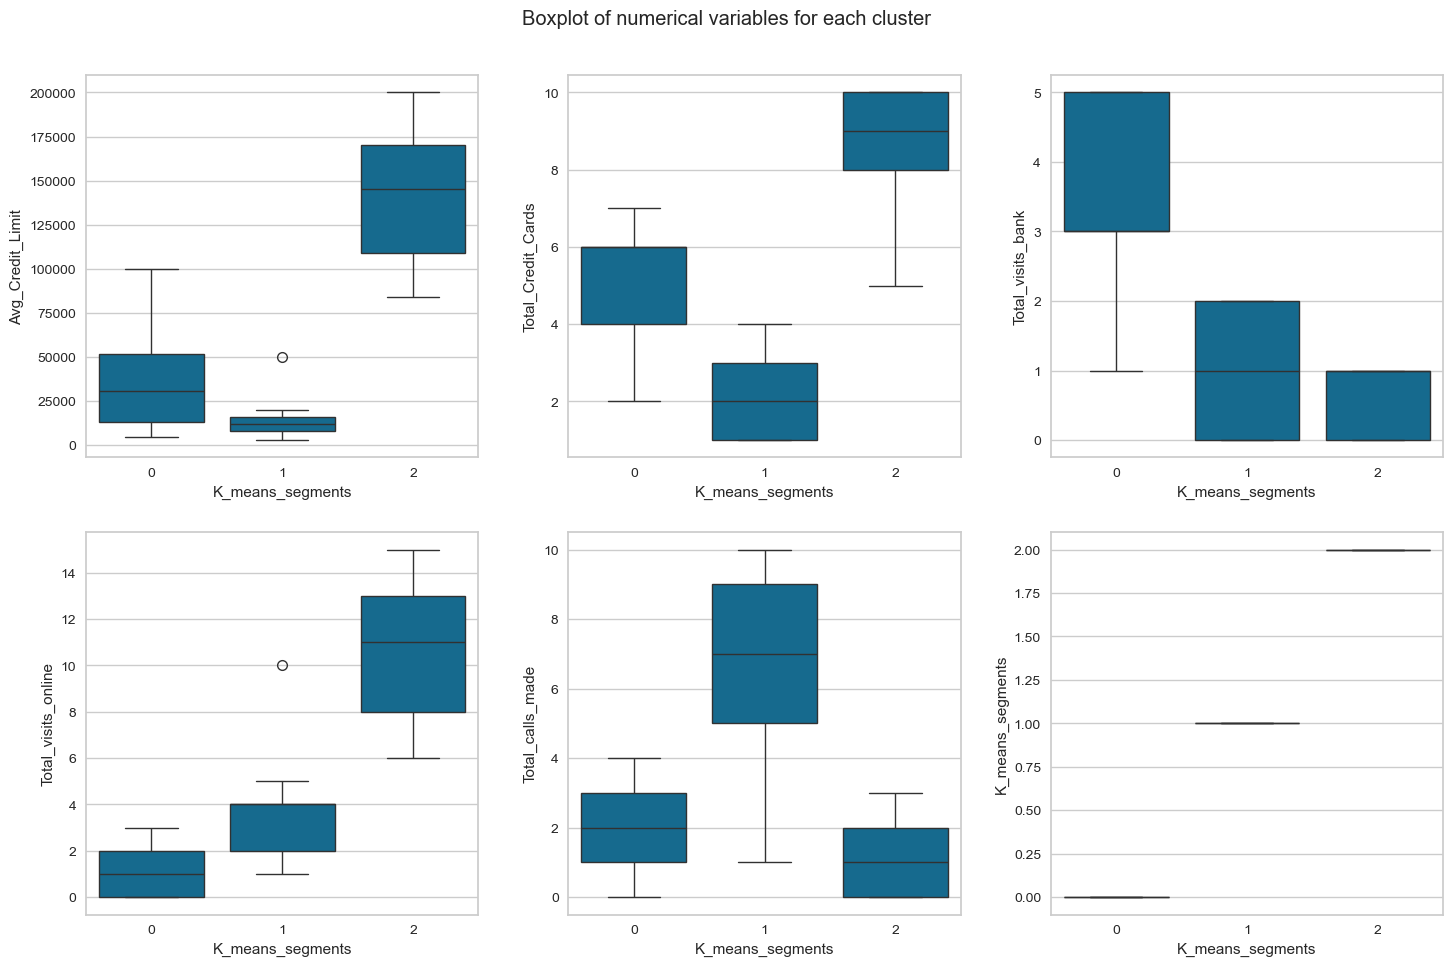

In [38]:
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplot of numerical variables for each cluster")
num_col = d_Attr_1.columns
for i, variable in enumerate(num_col):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=d_Attr_1, x="K_means_segments", y=variable)

plt.tight_layout(pad=2.0)

## Hierarchical Clustering

### Checking Cophenetic Correlation

In [39]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df_hc, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df_hc))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5422791209801746.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

In [40]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


**Let's explore different linkage methods with Euclidean distance only.**

In [41]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df_hc, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df_hc))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [42]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


### Checking Dendrograms

**Let's see the dendrograms for the different linkage methods.**

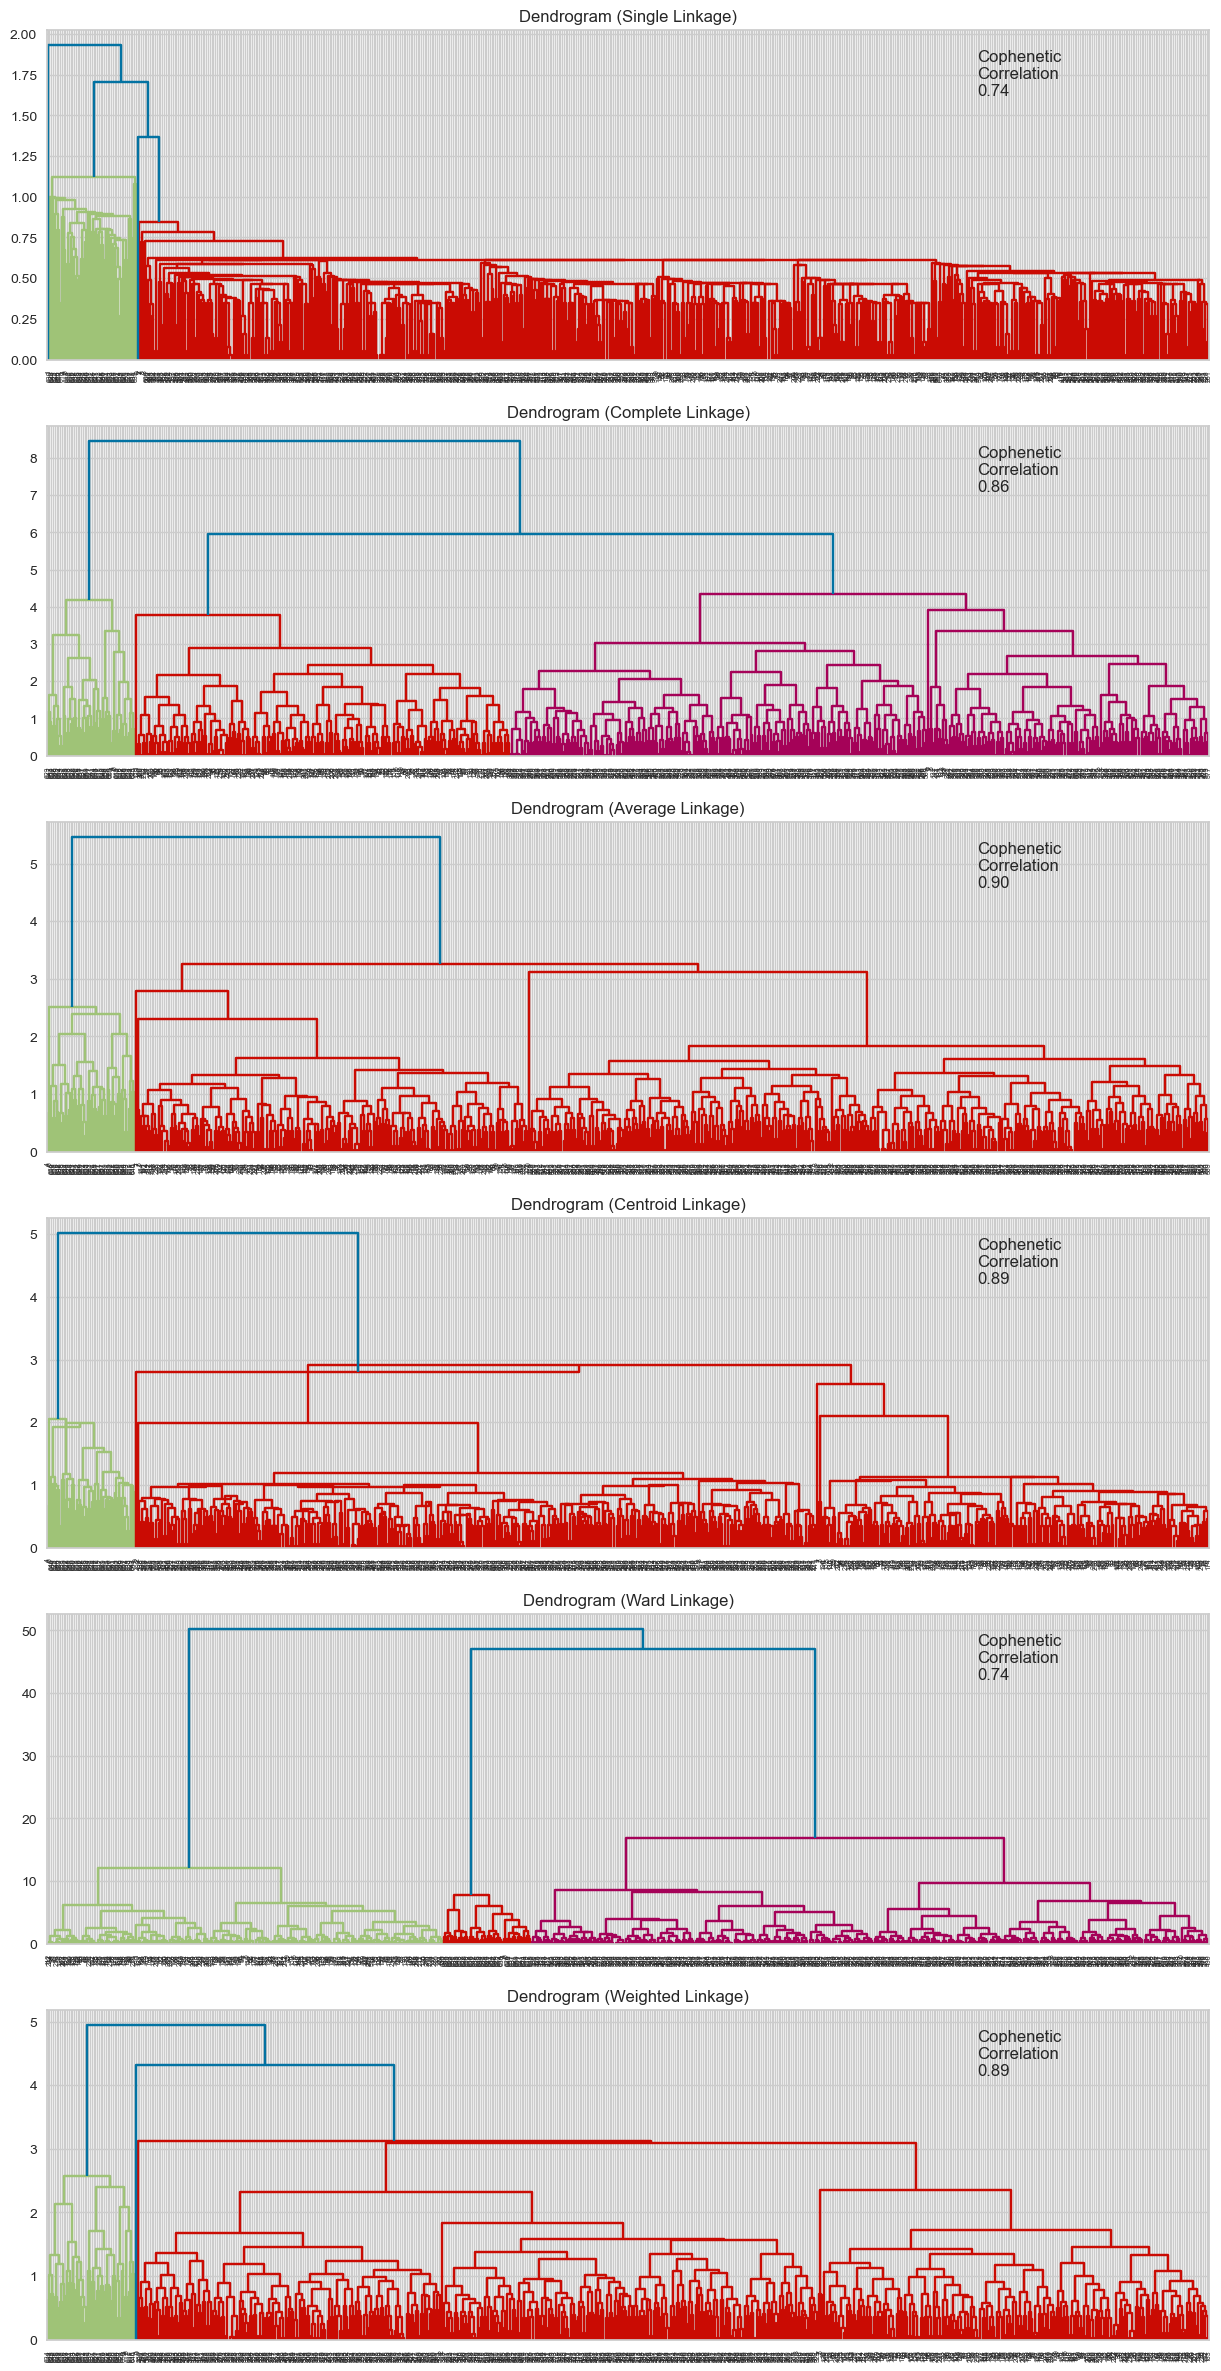

In [43]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df_hc, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df_hc))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

In [44]:
HCmodel = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df_hc)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [45]:
predictions_hc = HCmodel.fit_predict(subset_scaled_df_hc)
hierarchical_silhouette_score = silhouette_score(subset_scaled_df_hc, predictions_hc)
hierarchical_silhouette_score

0.515922432650965

In [46]:
subset_scaled_df_hc["HC_Clusters"] = HCmodel.labels_
d_Attr_2["HC_Clusters"] = HCmodel.labels_

In [47]:
cluster_profile_hc = d_Attr_2.groupby("HC_Clusters").mean()

In [48]:
cluster_profile_hc["count_in_each_segments"] = d_Attr_2.groupby("HC_Clusters")["Total_Credit_Cards"].count()


In [49]:
# let's display cluster profiles
cluster_profile_hc.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


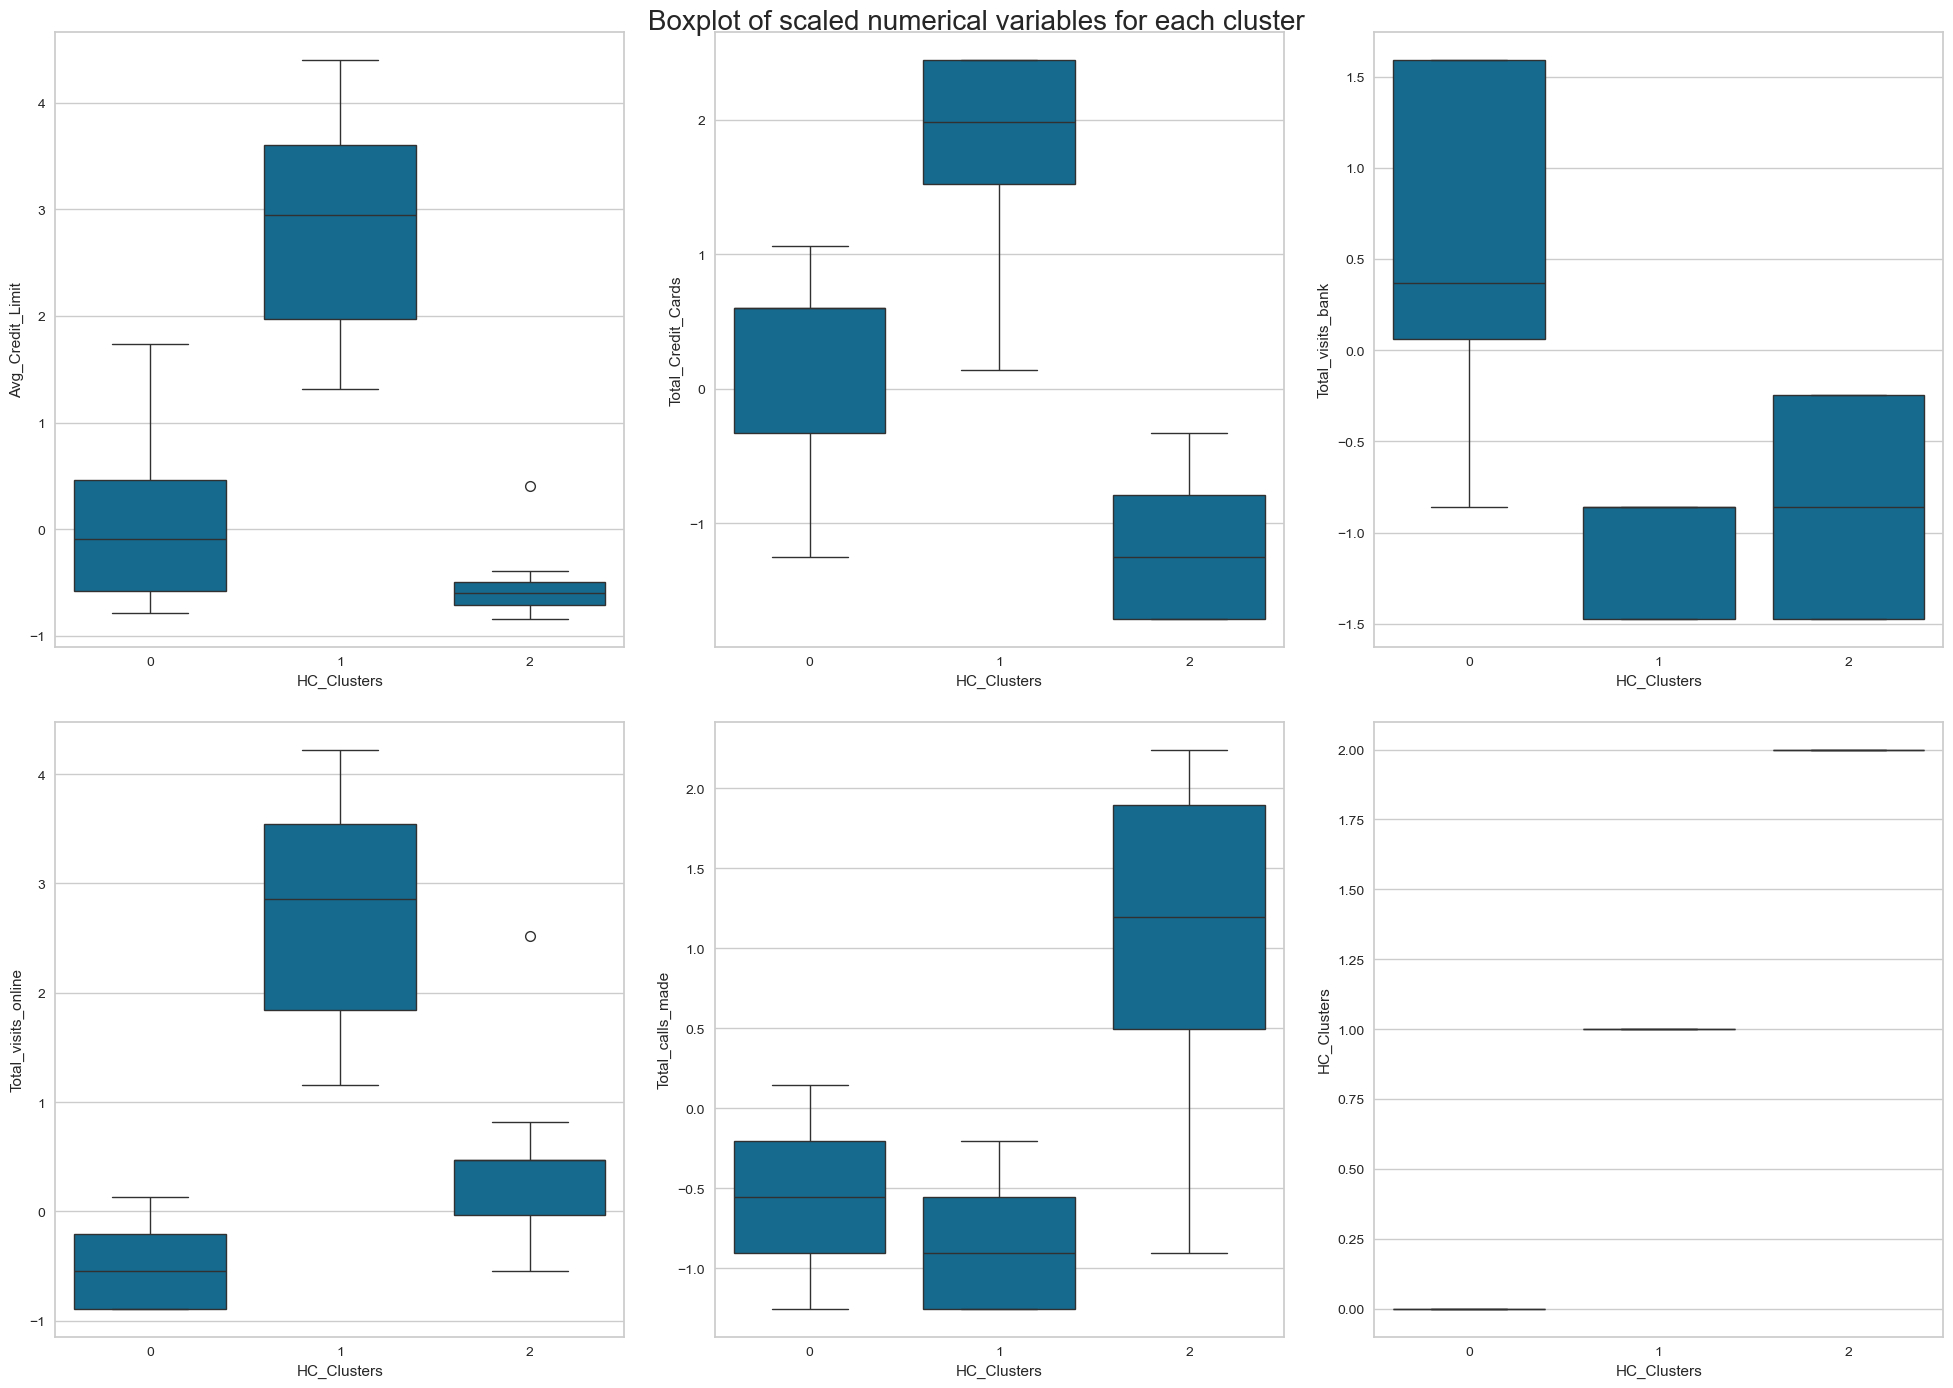

In [50]:
plt.figure(figsize=(20, 35))
plt.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
num_cols = d_Attr_2
for i, variable in enumerate(num_cols):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(data=subset_scaled_df_hc, x="HC_Clusters", y=variable)

plt.tight_layout(pad=2.0)

## Comparing Clusters

### Silhouette Scores

In [51]:
print(f"K-means Silhouette Score: {k_means_silhouette_score}")
print(f"Hierarchical Clustering Silhouette Score: {hierarchical_silhouette_score}")

K-means Silhouette Score: 0.5157182558881063
Hierarchical Clustering Silhouette Score: 0.515922432650965


### Cluster Profile (K-Means)

In [52]:
cluster_profile_km

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_of_customers
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


### Cluster Profile (Hierarchical Clustering)

In [53]:
cluster_profile_hc

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


## Groups obtained

- **Group 1**
   - **Moderate Financial group**
   - Avg. Credit limit: ~ 33700 
   - Largest cluster with 386 or 387 customers based on clustering type.
   - This group has balanced approach across calls and bank visits.
   - This group has lowest online visits.
- **Group 2**
   - **Low financial Customer group**
   - Avg. Credit limit: ~ 12200
   - This group has the lowest credit limit and lowest credit card usage.
   - This group is highly relied on call support
- **Group 3**
   - **High-Value Customer Group**
   - Avg. Credit limit:  141,040
   - Smallest cluster with only 50 customers.
   - This group has the highest credit card usage (8.7) and highest credit limit.
   - Mostly involved in online banking visits with no need for in-person contacts.
